In [1]:
#READING AND CROPPING IMAGES
#print(dont)
import numpy as np
from scipy.optimize import curve_fit
import csv
import imageio
from astropy.io import fits



def gaussian(x, amplitude, mean, stddev):
	return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)

def fit_gaussian(x, y):
	p0 = [np.max(y), np.argmax(y), 1.0]  # Initial guess for parameters
	popt, _ = curve_fit(gaussian, x, y, p0=p0)
	return popt

def calculate_fwhm(stddev):
	return 2 * np.sqrt(2 * np.log(2)) * stddev

data_path = '/mnt/AR-Drive-2/OpenLab/Spectroscope Data Observations/spectoscope/Procyon/04_29_03'
stellar_source = 'Procyon'
file_name_id = 'procyon'
num_of_images = 100

file_array = []
skip_indexes = [14, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]#, 45, 47, 48, 49, 50]
skip_indexes=[]

# Creating a CSV file for saving the cropped data
output_file_name = stellar_source + '-Data-Cropped.csv'
with open(output_file_name, 'w', newline='') as csvfile:
	fieldnames = ['file_number'] + [f'p{i}' for i in range(1, 1921)]
	writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
	writer.writeheader()
	
	for i in range(1, num_of_images + 1):
		
		if i in skip_indexes:
			continue
		
		#print(i)
		file_name = '/' + file_name_id + '_' + str(f'{i:05}') + '.fits'
		#image = imageio.imread(data_path + file_name)

		with fits.open(data_path + file_name) as hdul:
			image = hdul[0].data
			
		intensity_values_along_y = np.sum(image, axis=0)
		
		intensity_values_along_x = np.sum(image, axis=1)

		y_values = np.arange(len(intensity_values_along_x))
		params = fit_gaussian(y_values, intensity_values_along_x)
		fit_curve = gaussian(y_values, *params)

		fwhm = calculate_fwhm(params[2])
		#print(f'Full Width at Half Maximum (FWHM): {fwhm}')

		# Extract pixel range within FWHM
		fwhm_range = np.where(fit_curve >= params[0] / 2)[0]
		min_pixel, max_pixel = fwhm_range[0], fwhm_range[-1]

		#print(f'Taking vertical pixel range within FWHM: {min_pixel-20} to {max_pixel+20}')

		cropped_image = image[min_pixel-20:max_pixel + 21, :]

		new_intensity_values_along_y = np.sum(cropped_image, axis=0)

		writer.writerow({
			'file_number': i,
			**{f'p{i}': val for i, val in enumerate(new_intensity_values_along_y, start=1)}
		})

In [2]:
#PLOTTING SPECTRA AND EXTRACTING DIPS DATA
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
from scipy.signal import savgol_filter


calibration_coefficients = [-7.87006027e-05, -3.80749635e-02,  7.11501856e+02]

def calibrate_spectrum(pixel_positions):
	return np.polyval(calibration_coefficients, pixel_positions)

prominence = 8e3  # Adjust as needed

file_array = []

# Create and open a CSV file for saving the peaks
output_file_name_cropped_data = stellar_source + '-Data-Cropped.csv'

#print(df)
h_balmer_lines = [6563, 4861]
shift_wave = 147.5

df = pd.read_csv(output_file_name_cropped_data)

dips_wavelength_data = []


for index, row in df.iterrows():
	new_intensity_values_along_y = row.iloc[1:].values
	new_intensity_values_along_y = new_intensity_values_along_y * 3e6 / np.max(new_intensity_values_along_y)

	calibrated_wavelengths = 10 * calibrate_spectrum(range(len(new_intensity_values_along_y)))
	#print(calibrated_wavelengths)
	# Find dips in the specified wavelength ranges
	smoothed_intensity = savgol_filter(new_intensity_values_along_y, window_length=55, polyorder=3)
	new_intensity_values_along_y = smoothed_intensity

	# fig, axs = plt.subplots(len(h_balmer_lines)+1, 1, figsize=(10, 6 * len(h_balmer_lines)))

	final_dips = []
	dips_wavelengths = []

	for i, wavelength in enumerate(h_balmer_lines):
		shift_wave = 150
		shift_wave = shift_wave if i == 0 else shift_wave + 150
		min_wavelength, max_wavelength = wavelength - shift_wave, wavelength + shift_wave
		#print(min_wavelength,max_wavelength)

		indices_in_range = np.where((calibrated_wavelengths >= min_wavelength) & (calibrated_wavelengths <= max_wavelength))[0]
		#print(len(indices_in_range))
		min_distance = len(indices_in_range)/3
		
		wavelength_range_for_line = calibrated_wavelengths[indices_in_range]
		intensity_values_along_y_new = new_intensity_values_along_y[indices_in_range]
		prominence = (np.max(intensity_values_along_y_new) - np.min(intensity_values_along_y_new))
		prominence = prominence/10 if i == 0 else prominence/1000

		dips_in_range, _ = find_peaks(-intensity_values_along_y_new, distance=min_distance, prominence=prominence)
		dips_in_range = [dips_in_range[0]]
		#print(dips_in_range[0])
		#print(final_dips)

		lookup_wavelengths = [wavelength_range_for_line[pixel_position] for pixel_position in dips_in_range]

		lookup_indices = [np.argmin(np.abs(calibrated_wavelengths - wavelength)) for wavelength in lookup_wavelengths]
		final_dips.append(lookup_indices[0])
		dips_wavelengths.append({pixel_position: calibrated_wavelengths[pixel_position] for pixel_position in lookup_indices})
		print(dips_wavelengths)

		### Plot and print dips within the specified range

	# 	axs[i].plot(wavelength_range_for_line, intensity_values_along_y_new, color='blue', label='Calibrated & Smoothed Spectrum')
	# 	axs[i].plot([wavelength_range_for_line[pixel_position] for pixel_position in dips_in_range], [intensity_values_along_y_new[pixel_position] for pixel_position in dips_in_range], 'ro', markersize=5, label='Detected Dips')
	# 	axs[i].set_title('Smoothed Spectrum')
	# 	axs[i].set_ylabel('Intensity')
	# 	axs[i].legend()
	# 	axs[i].grid(True)
	

	# axs[-1].plot(calibrated_wavelengths, new_intensity_values_along_y, color='blue', label='Calibrated & Smoothed Spectrum')
	# axs[-1].plot([calibrated_wavelengths[pixel_position] for pixel_position in final_dips], [new_intensity_values_along_y[pixel_position] for pixel_position in final_dips], 'ro', markersize=5, label='Detected Dips')
	# axs[-1].set_xlabel('Wavelength (A)')
	# axs[-1].set_ylabel('Intensity')
	# axs[-1].set_title(f'Star Spectrum with Detected Dips for {stellar_source} (Absorption Features)')
	# axs[-1].legend()
	# axs[-1].grid(True)

	# plt.show()
	# plt.close()
		
	print(row.iloc[0])
	print(f'Detected Dips (Absorption Features) in Range:')
	print(dips_wavelengths)
	print()
	extracted_wavelengths = [list(d.values())[0] for d in dips_wavelengths]
	#print(extracted_wavelengths)
	dips_wavelength_data.append({index: extracted_wavelengths})

#print(dips_wavelength_data)

flat_data = [{'Image': list(d.keys())[0], 'H-alpha': list(d.values())[0][0], 'H-beta': list(d.values())[0][1]} for d in dips_wavelength_data]

# Create a DataFrame from the flat_data
df_data2 = pd.DataFrame(flat_data)

output_file_name_dips_data = stellar_source + '-Data-Dips.csv'

df_data2.to_csv(output_file_name_dips_data, index=False)
#print(df_data2)


[{659: 6522.322786123413}]
[{659: 6522.322786123413}, {1429: 4963.828757203893}]
1
Detected Dips (Absorption Features) in Range:
[{659: 6522.322786123413}, {1429: 4963.828757203893}]

[{656: 6526.5697738049275}]
[{656: 6526.5697738049275}, {1426: 4971.711712730147}]
2
Detected Dips (Absorption Features) in Range:
[{656: 6526.5697738049275}, {1426: 4971.711712730147}]

[{657: 6525.155685256477}]
[{657: 6525.155685256477}, {1424: 4976.959146354047}]
3
Detected Dips (Absorption Features) in Range:
[{657: 6525.155685256477}, {1424: 4976.959146354047}]

[{656: 6526.5697738049275}]
[{656: 6526.5697738049275}, {1425: 4974.336216548125}]
4
Detected Dips (Absorption Features) in Range:
[{656: 6526.5697738049275}, {1425: 4974.336216548125}]

[{655: 6527.982288341325}]
[{655: 6527.982288341325}, {1426: 4971.711712730147}]
5
Detected Dips (Absorption Features) in Range:
[{655: 6527.982288341325}, {1426: 4971.711712730147}]

[{655: 6527.982288341325}]
[{655: 6527.982288341325}, {1423: 4979.58050214

In [3]:
#OPTIMAL SHIFT CALCULATION
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

output_file_name_dips_data = stellar_source + '-Data-Dips.csv'
df = pd.read_csv(output_file_name_dips_data)

h_balmer_lines = [6563, 4861]

#print(df)

# Extract relevant data from the DataFrame
image_numbers = df['Image'].values
observed_h_alpha = df['H-alpha'].values
#observed_na = df['Na'].values
observed_h_beta = df['H-beta'].values

# Initial guess for wavelength shifts (zeros for each image)
initial_shifts = np.zeros(len(image_numbers))

# Define a cost function (chi-squared) to minimize
def cost_function(shift):
    expected_h_alpha = observed_h_alpha + shift
    #expected_na = observed_na + shift
    expected_h_beta = observed_h_beta + shift
    #chi_squared = np.sum(((6563 - expected_h_alpha)**2 / 6563) + ((5895 - expected_na)**2 / 5895)  + ((4861 - expected_h_beta)**2 / 4861))
    chi_squared = np.sum(((6563 - expected_h_alpha)**2 / 6563) + ((4861 - expected_h_beta)**2 / 4861))
    
    return chi_squared

# Minimize the cost function to find optimal shifts
result = minimize(cost_function, initial_shifts, method='L-BFGS-B')

# Extract the optimal shifts
optimal_shifts = result.x

#print(optimal_shifts)
df['Optimal Shift'] = optimal_shifts
df.to_csv(output_file_name_dips_data, index=False)

print(df)


# Plot the results
# plt.plot(image_numbers, optimal_shifts, marker='o', linestyle='-', color='b')
# plt.xlabel('Image Number')
# plt.ylabel('Optimal Wavelength Shift in A')
# plt.title('Optimal Wavelength Shift for Stacking (Balmer Series)')
# plt.show()



    Image      H-alpha       H-beta  Optimal Shift
0       0  6522.322786  4963.828757     -41.765767
1       1  6526.569774  4971.711713     -48.103596
2       2  6525.155685  4976.959146     -50.515483
3       3  6526.569774  4974.336217     -49.609398
4       4  6527.982288  4971.711713     -48.701885
..    ...          ...          ...            ...
95     95  6569.625809  5049.762132    -111.260051
96     96  6573.712247  5049.762132    -113.001103
97     97  6580.491498  5067.770062    -126.231388
98     98  6581.842626  5067.770062    -126.807294
99     99  6581.842626  5072.901019    -129.754289

[100 rows x 4 columns]


In [4]:
#PLOTTING SPECTRA AND EXTRACTING DIPS DATA

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d



calibration_coefficients = [-7.87006027e-05, -3.80749635e-02,  7.11501856e+02]

def calibrate_spectrum(pixel_positions):
	return np.polyval(calibration_coefficients, pixel_positions)

min_distance = 10  # Adjust as needed
prominence = 1e4  # Adjust as needed

file_array = []

# Create and open a CSV file for saving the peaks
output_file_name_cropped_data = stellar_source + '-Data-Cropped.csv'
df = pd.read_csv(output_file_name_cropped_data)

#print(df)

output_file_name_cropped_data = stellar_source + '-Data-Cropped.csv'
df_spectra = pd.read_csv(output_file_name_cropped_data)

output_file_name_dips_data = stellar_source + '-Data-Dips.csv'
df_dips = pd.read_csv(output_file_name_dips_data)

weight_file = 'sensor-weight-data.csv'
df_weights = pd.read_csv(weight_file)


optimal_shifts = df_dips['Optimal Shift'].values

# Create bins
bin_width = 1
bins = np.arange(3000, 7500+bin_width, bin_width)  # Adjust bin width as needed5
#print(bins)
global_bins = np.zeros(len(bins) - 1)
global_intensity_sum = np.zeros(len(bins) - 1)
bin_intensity_values = [[] for _ in range(len(bins) - 1)]

def resample_weights(wavelength_range_vega, weight_vega, bins):
	interp_func = interp1d(wavelength_range_vega, weight_vega, kind='linear', fill_value='extrapolate')

	weights_resampled = interp_func(bins)
	
	return weights_resampled


for index, row in df_spectra.iterrows():
	new_intensity_values_along_y = row.iloc[1:].values
	new_intensity_values_along_y = new_intensity_values_along_y * 3 * 1e6 / np.max(new_intensity_values_along_y)
	
	calibrated_wavelengths = 10 * calibrate_spectrum(range(len(new_intensity_values_along_y)))
	spec_shift = optimal_shifts[index]
	calibrated_wavelengths = calibrated_wavelengths + spec_shift
	
	weights_source = resample_weights(df_weights['Wavelength(A)'], df_weights['Weight'], calibrated_wavelengths)

	bin_indices = np.digitize(calibrated_wavelengths, bins, right=True)

	for i, bin_index in enumerate(bin_indices):
		if bin_index > 0 and bin_index < len(bins):
			global_bins[bin_index - 1] += 1
			global_intensity_sum[bin_index - 1] += new_intensity_values_along_y[i]*weights_source[i]
			bin_intensity_values[bin_index - 1].append(new_intensity_values_along_y[i]*weights_source[i])

	#print(global_bins)
	# if index == 0:
	# 	plt.figure(figsize=(10, 6))
	# 	plt.plot(calibrated_wavelengths, new_intensity_values_along_y, color='blue', label='Calibrated Spectrum')
	# 	plt.plot([calibrated_wavelengths[pixel_position] for pixel_position in dips], [new_intensity_values_along_y[pixel_position] for pixel_position in dips], 'ro', markersize=5, label='Detected Dips')
	# 	plt.xlabel('Wavelength (nm)')
	# 	plt.ylabel('Intensity')
	# 	plt.title('Star Spectrum with Detected Dips (Absorption Features)')
	# 	plt.legend()
	# 	plt.grid(True)
	# 	plt.show()
	# 	plt.close()

	# 	print(index)
	# 	print('Detected Dips (Absorption Features):')
	# 	for pixel_position, wavelength in dips_wavelengths.items():
	# 		print(f'Pixel Position: {pixel_position}, Wavelength: {wavelength} nm')
	# 	print()

# Print counts for each bin
# print("Global Bin Counts:")
# print(global_bins)
# print(global_intensity_sum/global_bins)

bin_std_dev = [np.std(values) for values in bin_intensity_values]
bin_std_dev = np.array(bin_std_dev)

bins = bins[:-1] + bin_width
global_mean_intensity = global_intensity_sum / global_bins
global_mean_intensity = np.nan_to_num(global_mean_intensity, nan=0, posinf=0, neginf=0)
non_zero_mask = global_mean_intensity != 0
global_mean_intensity = global_mean_intensity[non_zero_mask]
bins = bins[non_zero_mask]

bin_std_dev = bin_std_dev[non_zero_mask]

smooth = savgol_filter(global_mean_intensity, window_length=30, polyorder=5)
dips, _ = find_peaks(-smooth, distance=min_distance, prominence=prominence)
dips_wavelengths = {pixel_position: bins[pixel_position] for pixel_position in dips}

/home/royabhinav/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/royabhinav/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/royabhinav/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_6292/3819574343.py:102: RuntimeWarning: invalid value encountered in divide
  global_mean_intensity = global_intensity_sum / global_bins


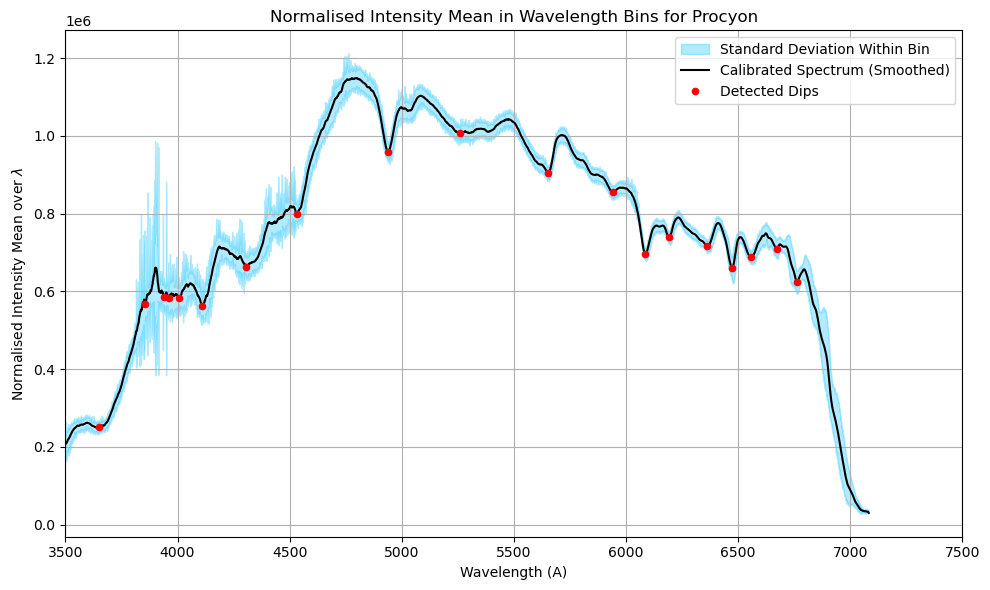

In [5]:
#PLOTTING SPECTRA
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.fill_between(bins, global_mean_intensity - bin_std_dev, global_mean_intensity + bin_std_dev, color='deepskyblue', alpha=0.3, label='Standard Deviation Within Bin')
#plt.plot(bins, global_mean_intensity,'b-', label='Mean Normalised Spectrum',markersize=3)
plt.plot(bins, smooth, linestyle='solid', color='black', label='Calibrated Spectrum (Smoothed)')
plt.plot([bins[pixel_position] for pixel_position in dips], [smooth[pixel_position] for pixel_position in dips], 'ro', markersize=4.5, label='Detected Dips')
plt.xlabel('Wavelength (A)')
plt.ylabel('Normalised Intensity Mean over $\lambda$')
plt.title(f'Normalised Intensity Mean in Wavelength Bins for {stellar_source}')
plt.xlim(3500,7500)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()